In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import torch

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/torchtext-yelpreviewfull/yelp_test.csv
/kaggle/input/torchtext-yelpreviewfull/yelp_train.csv


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cuda'

# 1) Exploratory Data Analysis

In [3]:
train_df = pd.read_csv("/kaggle/input/torchtext-yelpreviewfull/yelp_train.csv", names=['label', 'text'])
test_df = pd.read_csv("/kaggle/input/torchtext-yelpreviewfull/yelp_test.csv", names=['label', 'text'])

In [4]:
train_df.shape, test_df.shape

((650000, 2), (50000, 2))

In [5]:
train_df.head()

,label,text
0,5,dr. goldberg offers everything i look for in a...
1,2,"Unfortunately, the frustration of being Dr. Go..."
2,4,Been going to Dr. Goldberg for over 10 years. ...
3,4,Got a letter in the mail last week that said D...
4,1,I don't know what Dr. Goldberg was like before...


In [6]:
test_df.head()

,label,text
0,1,I got 'new' tires from them and within two wee...
1,1,Don't waste your time. We had two different p...
2,1,All I can say is the worst! We were the only 2...
3,1,I have been to this restaurant twice and was d...
4,1,Food was NOT GOOD at all! My husband & I ate h...


In [7]:
# Even amount of every label. Definitely a multiclassification dataset.
train_df['label'].value_counts()

label
5    130000
2    130000
4    130000
1    130000
3    130000
Name: count, dtype: int64

# 2) Preprocessing

In [8]:
import torchtext
from torchtext.data.utils import get_tokenizer


''' First get tokenizer ready for other function soon. Tokenizers are used in nlp to turn strings/sentences 
    into tokens. Ex: "The cat is sleeping" will become ['The', 'cat', 'is', 'sleeping'].

    tk = tokenizer '''

tk = get_tokenizer('basic_english')

In [9]:
# Example sentence for display
ex_sent = "This is a cool sentence."

tk(ex_sent)

['this', 'is', 'a', 'cool', 'sentence', '.']

In [10]:
''' Steps for preprocessing :
    
    1) Lower text - "What" and "what" will be looked at as 2 different entities if not lowered.
    
    2) Remove non number/alpha chars - No need for !, #, etc.
    
    3) Tokenization - Explained above
    
    4) .join - ' '.join(["Some", "string", "here"]) will produce "'Some string here'" so join puts
        it back together.
    
    sent = sentence
'''

def preprocessing(sent, print_steps=False):
    if print_steps is True:
        print(f'1) --- Current text:\n{sent}')
    sent = sent.lower()
    if print_steps is True:
        print(f'2) --- Post lower:\n{sent}')
    
    
    ''' Explanation of regex.
        \s - Finds single whitespace char
        \w - Matches char in str
    
        Observations:
            1) Doing " r'^\w " - Goes through the entire str, remember the rule google said:
                "The search proceeds through the string from start to end"

            2) re.sub(r'\w', '', test_sent) - Matches every char, so [a-zA-Z0-9_]. Replaces
                with nothing. Hence "'$  @ !!!'" returned.
            3) re.sub(r'\s', '', test_sent) - Matches every white space. And replace it with
                nothing, hence "'Th$sis@32434test!!!'"
            4) re.sub(r'[\w\s]', '', test_sent) - w gets rid of all chars its supposed to like
                [a-zA-Z0-9_] and also \s gets rid of all white spaces. Hence "'$@!!!'"

            Why does ^ reverse it and remove special chars? 
            Answer: 
            "An up-hat (^) at the start of a square-bracket set inverts it, so [^ab] means 
            any char except 'a' or 'b'." from google source:
            https://developers.google.com/edu/python/regular-expressions
            So both \w\s say together "Let's replace all chars [a-zA-Z0-9_] and white spaces
            with nothing". BUT, the ^ stops and says do the opposite of that and instead
            keeps all the matching chars and white spaces. It's genius. '''
    sent = re.sub(r'[^\w\s]', '', sent)
    if print_steps is True:
        print(f'3) --- Post regex sub (remove non alpha numerical chars):\n{sent}')
    
    sent = tk(sent)
    if print_steps is True:
        print(f'4) --- Post tokenization:\n{sent}')
        
    sent = ' '.join(sent)
    if print_steps is True:
        print(f'5) --- Post join:\n{sent}')
        
    return sent
    
    
# Example
preprocessing("Shocking!!! How could group 46 do that?!", True)

1) --- Current text:
Shocking!!! How could group 46 do that?!
2) --- Post lower:
shocking!!! how could group 46 do that?!
3) --- Post regex sub (remove non alpha numerical chars):
shocking how could group 46 do that
4) --- Post tokenization:
['shocking', 'how', 'could', 'group', '46', 'do', 'that']
5) --- Post join:
shocking how could group 46 do that


'shocking how could group 46 do that'

In [11]:
# Examples from dataframe. Zip can take a range and loop only that many times. 
for i, x in zip(range(2), train_df['text']):
    preprocessing(x, True)
    print('\n\n\n')

1) --- Current text:
dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank.
2) --- Post lower:
dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do yo

In [12]:
# .apply takes a function, every row of column is given to it for processing.
train_df['preprocessed_sentences'] = train_df['text'].apply(preprocessing)

train_df.head()

,label,text,preprocessed_sentences
0,5,dr. goldberg offers everything i look for in a...,dr goldberg offers everything i look for in a ...
1,2,"Unfortunately, the frustration of being Dr. Go...",unfortunately the frustration of being dr gold...
2,4,Been going to Dr. Goldberg for over 10 years. ...,been going to dr goldberg for over 10 years i ...
3,4,Got a letter in the mail last week that said D...,got a letter in the mail last week that said d...
4,1,I don't know what Dr. Goldberg was like before...,i dont know what dr goldberg was like before m...


In [13]:
# Same with test df
test_df['preprocessed_sentences'] = test_df['text'].apply(preprocessing)

test_df.head()

,label,text,preprocessed_sentences
0,1,I got 'new' tires from them and within two wee...,i got new tires from them and within two weeks...
1,1,Don't waste your time. We had two different p...,dont waste your time we had two different peop...
2,1,All I can say is the worst! We were the only 2...,all i can say is the worst we were the only 2 ...
3,1,I have been to this restaurant twice and was d...,i have been to this restaurant twice and was d...
4,1,Food was NOT GOOD at all! My husband & I ate h...,food was not good at all my husband i ate here...


# 3) Splitting

In [14]:
from sklearn.model_selection import train_test_split

''' In the colab ag news lstm project, I got beautiful results on train and valid acc and losses. I 
    suspected because the dataset was smaller, it'd do better because model wouldn't have too much 
    training data to even overfit on. 

    Lstm ag news project:
       1) train size - 120k
       2) test size - 7600
       3) train test split used with 0.2 so 20% of train data will be validation data. 
       4) so train data is 96k, and test is 24k

    Yelp project
       1) train size - 650k
       2) test size - 50k
       3) train test split used with 0.2 so 20% of train data will be validation data. 
       4) so train data is 520k, and test is 130k. 

    Point is, in first one, there's a 72k difference between train and valid set. The 
    second has a 390k difference! That's SO much more massive. So maybe setting test size 
    to half would help.
    
        ***New test_size values***
        1) 0.45 - Train will be 357,500. Test will be 292,500. That's a 64,500 difference. MUCH
            better than the last difference of 130k.
'''
split_test_size = 0.45

x_train, x_val, y_train, y_val = train_test_split(train_df['preprocessed_sentences'],
                                                  train_df['label'],
                                                  test_size=split_test_size) 
# Display a few
num_to_display = 3
print(f'x_train:\n{x_train[:num_to_display]}\n\ny_train:\n{y_train[:num_to_display]}')

x_train:
93324     spent a few hours here saturday afternoon bowl...
64881     andrew j and i grabbed boba here before drivin...
277348    if youre on the strip and want a good burger t...
Name: preprocessed_sentences, dtype: object

y_train:
93324     3
64881     4
277348    3
Name: label, dtype: int64


In [15]:
len(x_train), len(y_train)

(357500, 357500)

In [16]:
len(x_val), len(y_val)

(292500, 292500)

In [17]:
# Correct the indices
x_train.reset_index(drop=True, inplace=True)
x_val.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

print(f'x_train:\n{x_train.head()}\n\ny_train:\n{y_train.head()}\n\n')
print(f'x_val:\n{x_val.head()}\n\ny_val:\n{y_val.head()}\n\n')

x_train:
0    spent a few hours here saturday afternoon bowl...
1    andrew j and i grabbed boba here before drivin...
2    if youre on the strip and want a good burger t...
3    i loveloveloved this hotel i did a site visit ...
4    the food was way overpriced in my opinion but ...
Name: preprocessed_sentences, dtype: object

y_train:
0    3
1    4
2    3
3    5
4    2
Name: label, dtype: int64


x_val:
0    i have been to the dd many times they host the...
1    not the best ive had the service is not good t...
2    i was walking to lucilles bbq to celebrate a f...
3    we stumbled across this new restaurantlounge t...
4    gas scam nif you do not have gas receipt even ...
Name: preprocessed_sentences, dtype: object

y_val:
0    4
1    2
2    5
3    4
4    1
Name: label, dtype: int64




# 4) Tokenize training text

In [18]:
x_train_tokens = [tk(sent) for sent in x_train]
x_val_tokens = [tk(sent) for sent in x_val]

# Display a few
print(f'{num_to_display} x_train sentences:\n{x_train[:num_to_display]}\n')
print(f'THEN {num_to_display} x_train_tokens sentences:\n{x_train_tokens[:num_to_display]}\n\n\n')

print(f'{num_to_display} x_val sentences:\n{x_val[:num_to_display]}\n')
print(f'THEN {num_to_display} x_val_tokens sentences:\n{x_val_tokens[:num_to_display]}')

3 x_train sentences:
0    spent a few hours here saturday afternoon bowl...
1    andrew j and i grabbed boba here before drivin...
2    if youre on the strip and want a good burger t...
Name: preprocessed_sentences, dtype: object

THEN 3 x_train_tokens sentences:
[['spent', 'a', 'few', 'hours', 'here', 'saturday', 'afternoon', 'bowling', 'and', 'playing', 'video', 'games', 'with', 'my', 'little', 'bro', 'and', 'im', 'going', 'to', 'try', 'to', 'not', 'let', 'the', 'fact', 'that', 'i', 'bowled', '5', 'strikes', 'in', 'my', 'best', 'game', 'ever', 'affect', 'my', 'review', 'of', 'the', 'place', '5', 'strikes', 'unbelievable', 'my', 'little', 'bro', 'was', 'so', 'impressed', 'i', 'didnt', 'have', 'the', 'heart', 'to', 'tell', 'him', 'i', 'normally', 'suck', 'nngoodnservice', 'was', 'friendly', 'and', 'helpful', 'had', 'several', 'folks', 'stop', 'by', 'while', 'we', 'were', 'bowling', 'just', 'to', 'see', 'how', 'we', 'were', 'doing', 'and', 'if', 'we', 'needed', 'anything', 'also', 'lost

# 5) Building vocab

In [19]:
from torchtext.vocab import build_vocab_from_iterator

def get_tokenized_sentences(sentences):
    for sent in sentences:
        yield tk(sent)

# Get all preprocessed sentences into a list and create list for tokenized sentences
all_sentences = train_df['preprocessed_sentences'].values.tolist()


''' To build vocab in pytorch, use build_vocab_from_iterator (bvfi). It takes a function as an arg, and 
    that function takes an interable. Function must use yield and yield will pause every iteration to 
    continue from where it left off. 
    
    "unk" key is for when the vocab gets unknown words. When the vocab is built, it will KNOW, n amount
    of words. However if a new word comes in and it's not familar with it, it'll be classified as 
    unk for unknown. '''

vocab = build_vocab_from_iterator(get_tokenized_sentences(all_sentences), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [20]:
# Get entire dictionary which contains key,value pairs of string/ints
d = vocab.get_stoi()

# Display a few. Each string with an assigned number.
for index, key_value in zip(range(5), d.items()):
    print(f'Key: {key_value[0]}. Value: {key_value[1]}')

Key: zzzzzzzzzzzznnbut. Value: 837409
Key: zzzzzzzzznnmy. Value: 837405
Key: zzzzzzzzznclick. Value: 837404
Key: zzzzzzzznnwake. Value: 837403
Key: zzzzzzzznn45. Value: 837402


In [21]:
# Can now convert whole sentences into nums. Example below.
def convert_sent_to_nums(sent, print_steps=False):
    if print_steps is True:
        print(f'Sentence (as it is):\n{sent}\n')
    return vocab(tk(sent))

c = convert_sent_to_nums(train_df['preprocessed_sentences'][0], True)
print(f'Converted sentence:\n{c}')

Sentence (as it is):
dr goldberg offers everything i look for in a general practitioner hes nice and easy to talk to without being patronizing hes always on time in seeing his patients hes affiliated with a topnotch hospital nyu which my parents have explained to me is very important in case something happens and you need surgery and you can get referrals to see specialists without having to see him first really what more do you need im sitting here trying to think of any complaints i have about him but im really drawing a blank

Converted sentence:
[1046, 46721, 1378, 192, 4, 257, 9, 10, 3, 1108, 14001, 1338, 85, 2, 613, 5, 731, 5, 325, 165, 9640, 1338, 126, 20, 50, 10, 976, 187, 3502, 1338, 10462, 17, 3, 5955, 2437, 204992, 63, 13, 1617, 22, 1071, 5, 34, 11, 40, 1483, 10, 805, 166, 1750, 2, 19, 222, 3574, 2, 19, 74, 42, 14061, 5, 145, 13641, 325, 334, 5, 145, 251, 104, 59, 61, 68, 82, 19, 222, 86, 528, 43, 356, 5, 121, 7, 130, 1445, 4, 22, 55, 251, 14, 86, 59, 8526, 3, 5671]


In [22]:
# Loop up the above values just to double check
[vocab.get_itos()[num] for num in c]

['dr',
 'goldberg',
 'offers',
 'everything',
 'i',
 'look',
 'for',
 'in',
 'a',
 'general',
 'practitioner',
 'hes',
 'nice',
 'and',
 'easy',
 'to',
 'talk',
 'to',
 'without',
 'being',
 'patronizing',
 'hes',
 'always',
 'on',
 'time',
 'in',
 'seeing',
 'his',
 'patients',
 'hes',
 'affiliated',
 'with',
 'a',
 'topnotch',
 'hospital',
 'nyu',
 'which',
 'my',
 'parents',
 'have',
 'explained',
 'to',
 'me',
 'is',
 'very',
 'important',
 'in',
 'case',
 'something',
 'happens',
 'and',
 'you',
 'need',
 'surgery',
 'and',
 'you',
 'can',
 'get',
 'referrals',
 'to',
 'see',
 'specialists',
 'without',
 'having',
 'to',
 'see',
 'him',
 'first',
 'really',
 'what',
 'more',
 'do',
 'you',
 'need',
 'im',
 'sitting',
 'here',
 'trying',
 'to',
 'think',
 'of',
 'any',
 'complaints',
 'i',
 'have',
 'about',
 'him',
 'but',
 'im',
 'really',
 'drawing',
 'a',
 'blank']

In [23]:
# Now convert all preprocessed strings and display a few
x_train_sequences = [vocab(tk(text)) for text in x_train]
x_val_sequences = [vocab(tk(text)) for text in x_val]

print(f'x_train_sequences:\n{x_train_sequences[:num_to_display]}\n')
print(f'x_val_sequences:\n{x_val_sequences[:num_to_display]}\n')

x_train_sequences:
[[743, 3, 147, 379, 43, 582, 988, 2965, 2, 931, 2094, 1096, 17, 13, 97, 7374, 2, 86, 114, 5, 112, 5, 21, 327, 1, 466, 12, 4, 15040, 202, 6500, 10, 13, 109, 704, 163, 7449, 13, 296, 7, 1, 31, 202, 6500, 3421, 13, 97, 7374, 6, 26, 559, 4, 80, 22, 1, 1380, 5, 347, 251, 4, 1018, 2301, 591609, 6, 159, 2, 557, 23, 410, 1214, 471, 75, 156, 15, 24, 2965, 36, 5, 145, 117, 15, 24, 533, 2, 37, 15, 412, 247, 81, 889, 62, 5662, 10, 3, 2094, 704, 12, 142, 519, 2, 24, 4859, 598, 2, 325, 663419, 159, 1502, 410, 78, 1808, 17, 524549, 2010, 308, 86, 21, 58, 3973, 14, 86, 102, 162, 13, 2093, 27, 538, 375, 514, 2093, 2, 8, 160, 34, 3, 30, 1387, 137, 5, 2673, 139, 3, 2010, 17, 309, 218, 491348, 97, 3710, 9, 2965, 4, 236, 1449, 9, 120, 2, 3, 320, 1096, 1278, 71, 394, 5, 493, 901], [8173, 5172, 2, 4, 2172, 1981, 43, 132, 1354, 56, 5, 1, 10691, 16, 6, 30, 492, 4, 405, 1492, 4, 6, 3, 718813, 321, 3275, 25, 1, 705, 7, 276, 1981, 10, 2240, 25, 62949, 170, 4, 108, 1, 11414, 24, 28182, 490, 88, 

In [24]:
# Show example of original text in one of the x_train_sequences by converting
def convert_num_to_sentence(nums, print_steps=False):
    if print_steps is True:
        print(f'NUMERICAL sentence (as it is):\n{nums}\n')
    
    # get_itos gets a dictionary of int and str pairs. Pass num to get str equal
    s = [vocab.get_itos()[num] for num in nums]
    
    # Then join for original string
    return ' '.join(s)

convert_num_to_sentence(x_train_sequences[0], True)

NUMERICAL sentence (as it is):
[743, 3, 147, 379, 43, 582, 988, 2965, 2, 931, 2094, 1096, 17, 13, 97, 7374, 2, 86, 114, 5, 112, 5, 21, 327, 1, 466, 12, 4, 15040, 202, 6500, 10, 13, 109, 704, 163, 7449, 13, 296, 7, 1, 31, 202, 6500, 3421, 13, 97, 7374, 6, 26, 559, 4, 80, 22, 1, 1380, 5, 347, 251, 4, 1018, 2301, 591609, 6, 159, 2, 557, 23, 410, 1214, 471, 75, 156, 15, 24, 2965, 36, 5, 145, 117, 15, 24, 533, 2, 37, 15, 412, 247, 81, 889, 62, 5662, 10, 3, 2094, 704, 12, 142, 519, 2, 24, 4859, 598, 2, 325, 663419, 159, 1502, 410, 78, 1808, 17, 524549, 2010, 308, 86, 21, 58, 3973, 14, 86, 102, 162, 13, 2093, 27, 538, 375, 514, 2093, 2, 8, 160, 34, 3, 30, 1387, 137, 5, 2673, 139, 3, 2010, 17, 309, 218, 491348, 97, 3710, 9, 2965, 4, 236, 1449, 9, 120, 2, 3, 320, 1096, 1278, 71, 394, 5, 493, 901]



'spent a few hours here saturday afternoon bowling and playing video games with my little bro and im going to try to not let the fact that i bowled 5 strikes in my best game ever affect my review of the place 5 strikes unbelievable my little bro was so impressed i didnt have the heart to tell him i normally suck nngoodnservice was friendly and helpful had several folks stop by while we were bowling just to see how we were doing and if we needed anything also lost some quarters in a video game that wasnt working and were refunded quickly and without questionnfamily friendly environment several other groups with kidsnnbadnlimited ball selection im not an expert but im pretty sure my fingers are regular guy size fingers and it took me a good ten minutes to track down a ball with large enough holesna little pricy for bowling i thought shoes for two and a couple games ran us close to 30 bucks'

# 6) Padding

In [25]:
import torch
# Padding takes num sentences of different lengths into the same length.

# test pad value
max_len = 5 

# Get an example num sentence
test_num_sent = x_train_sequences[0]
print(f'Current numerical sentence:\n{test_num_sent}\nLength: {len(test_num_sent)}\n\n')

# Convert to tensor because .pad func in torch requires tensors
test_num_sent = torch.tensor(test_num_sent)
print(f'Current numerical sentence as tensor:\n{test_num_sent}\n\n')

''' "(0, max_len - len(test_num_sent))" - Does the math. 2 classes

    1) Length of sentence shorter than padded value - Ex: If sent is 20 nums long and
        padding value/max_len is 50, 30 0s is added. That's where the "0" value comes into 
        play in the arguments. "max_len - len(test_num_sent)" is 50 - 20 = 30, so 30 0s added.
        
    2) Length of sentence LONGER than padded value - Ex: If sent is 17 nums long and padding value/
        max_len is 5. The opposite happens. The sentence is chopped off or truncated to get to 
        max len of 5. "max_len - len(test_num_sent)" is 5 - 17 = -12 '''

test_num_sent = torch.nn.functional.pad(test_num_sent, (0, max_len - len(test_num_sent)), mode='constant', value=0)
print(f'Padded numerical sentence as tensor:\n{test_num_sent}\nNew length: {len(test_num_sent)}')

Current numerical sentence:
[743, 3, 147, 379, 43, 582, 988, 2965, 2, 931, 2094, 1096, 17, 13, 97, 7374, 2, 86, 114, 5, 112, 5, 21, 327, 1, 466, 12, 4, 15040, 202, 6500, 10, 13, 109, 704, 163, 7449, 13, 296, 7, 1, 31, 202, 6500, 3421, 13, 97, 7374, 6, 26, 559, 4, 80, 22, 1, 1380, 5, 347, 251, 4, 1018, 2301, 591609, 6, 159, 2, 557, 23, 410, 1214, 471, 75, 156, 15, 24, 2965, 36, 5, 145, 117, 15, 24, 533, 2, 37, 15, 412, 247, 81, 889, 62, 5662, 10, 3, 2094, 704, 12, 142, 519, 2, 24, 4859, 598, 2, 325, 663419, 159, 1502, 410, 78, 1808, 17, 524549, 2010, 308, 86, 21, 58, 3973, 14, 86, 102, 162, 13, 2093, 27, 538, 375, 514, 2093, 2, 8, 160, 34, 3, 30, 1387, 137, 5, 2673, 139, 3, 2010, 17, 309, 218, 491348, 97, 3710, 9, 2965, 4, 236, 1449, 9, 120, 2, 3, 320, 1096, 1278, 71, 394, 5, 493, 901]
Length: 166


Current numerical sentence as tensor:
tensor([   743,      3,    147,    379,     43,    582,    988,   2965,      2,
           931,   2094,   1096,     17,     13,     97,   7374,      2, 

In [26]:
# Out of curiosity what is the max length of numerical sentences? 
max_num = max(len(x) for x in x_train_sequences)

max_num

1025

In [27]:
# Get length of all num lists for graphing soon
x_train_lengths = [len(list_of_nums) for list_of_nums in x_train_sequences]

In [28]:
series_lengths = pd.Series(data=x_train_lengths)

series_lengths

0         166
1          74
2          44
3         215
4          22
         ... 
357495    340
357496    337
357497    213
357498     95
357499    271
Length: 357500, dtype: int64

<Axes: >

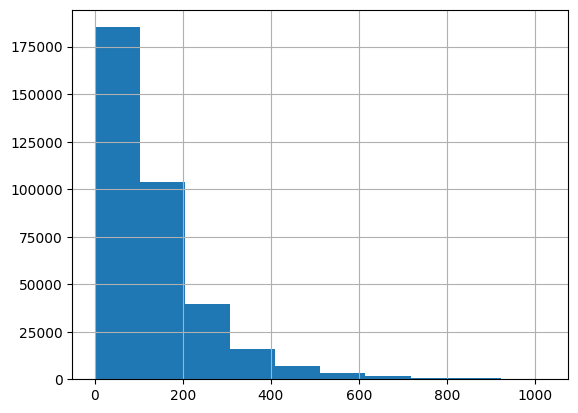

In [29]:
''' This shows padding to the max length probably isn't best. A few cells ago, the max len was 1033. 
    ALL other num sentences will have to be padded to that length. A waste of space and more processing
    time most likely.
    
    Padding to max len of 1033 will NOT be done, a smaller value will be chosen. '''
series_lengths.hist()

In [30]:
# Use same num sentence and pad to greater length as an example
test_num_sent = torch.tensor(x_train_sequences[0])

# "(len(test_num_sent) * 2) - len(test_num_sent)" Guarantees we'll have to pad and add 0s. '''

a = torch.nn.functional.pad(test_num_sent, 
                            (0, (len(test_num_sent) * 2) - len(test_num_sent)), 
                            mode='constant', 
                            value=0)

print(f'Test_num_sent:\n{test_num_sent}\nLength: {len(test_num_sent)}\nNew padded sent:\n{a}\nLength: {len(a)}')

Test_num_sent:
tensor([   743,      3,    147,    379,     43,    582,    988,   2965,      2,
           931,   2094,   1096,     17,     13,     97,   7374,      2,     86,
           114,      5,    112,      5,     21,    327,      1,    466,     12,
             4,  15040,    202,   6500,     10,     13,    109,    704,    163,
          7449,     13,    296,      7,      1,     31,    202,   6500,   3421,
            13,     97,   7374,      6,     26,    559,      4,     80,     22,
             1,   1380,      5,    347,    251,      4,   1018,   2301, 591609,
             6,    159,      2,    557,     23,    410,   1214,    471,     75,
           156,     15,     24,   2965,     36,      5,    145,    117,     15,
            24,    533,      2,     37,     15,    412,    247,     81,    889,
            62,   5662,     10,      3,   2094,    704,     12,    142,    519,
             2,     24,   4859,    598,      2,    325, 663419,    159,   1502,
           410,     78,  

In [31]:
# Pad all numerical sentences
def pad_num_sentences(num_sent, max_pad_length):
    # return torch.nn.functional.pad(torch.tensor(num_sent), (0, max_pad_length - len(num_sent)), mode='constant', value=0)
    
    # Type specification should solve error.
    return torch.nn.functional.pad(torch.tensor(num_sent, dtype=torch.int64), (0, max_pad_length - len(num_sent)), mode='constant', value=0)

# A few cells ago, decision was made not to use max of 1033, but a value closer to the range of most num sentences.
max_padding_len = 200

# cs = current sequence
x_train_padded = [pad_num_sentences(cs, max_padding_len) for cs in x_train_sequences]
x_val_padded = [pad_num_sentences(cs, max_padding_len) for cs in x_val_sequences]

# Display
print(f'x_train_padded:\n{x_train_padded[:num_to_display]}\n\n')
print(f'x_val_padded:\n{x_val_padded[:num_to_display]}\n\n')

x_train_padded:
[tensor([   743,      3,    147,    379,     43,    582,    988,   2965,      2,
           931,   2094,   1096,     17,     13,     97,   7374,      2,     86,
           114,      5,    112,      5,     21,    327,      1,    466,     12,
             4,  15040,    202,   6500,     10,     13,    109,    704,    163,
          7449,     13,    296,      7,      1,     31,    202,   6500,   3421,
            13,     97,   7374,      6,     26,    559,      4,     80,     22,
             1,   1380,      5,    347,    251,      4,   1018,   2301, 591609,
             6,    159,      2,    557,     23,    410,   1214,    471,     75,
           156,     15,     24,   2965,     36,      5,    145,    117,     15,
            24,    533,      2,     37,     15,    412,    247,     81,    889,
            62,   5662,     10,      3,   2094,    704,     12,    142,    519,
             2,     24,   4859,    598,      2,    325, 663419,    159,   1502,
           410,     78,

In [32]:
''' Checking types again. Old error was "Expected tensor for argument #1 'indices' to have one of the following scalar types: 
    Long, Int; but got torch.cuda.FloatTensor instead (while checking arguments for embedding)". In previous cell, the old
    pad line is commented out because that was used before, no type specification so I assume the function TRIED to assume
    the type. Didn't work out.
    
    Loop shouldn't print anything if all is well. '''

for i, cur_padded_tensor in enumerate(x_train_padded):
    if cur_padded_tensor.dtype != torch.int64:
        print(f'Index {i} has non int64 type!')

In [33]:
x_train_padded[0].dtype

torch.int64

# 7) Changing labels

In [34]:
''' 1,2,3,4 in set(y_train.values). .values is a numpy array while y_train currently is a 
    series object. '''
y_train_np = y_train.values
y_val_np = y_val.values

y_train_np, y_val_np

(array([3, 4, 3, ..., 2, 3, 1]), array([4, 2, 5, ..., 1, 4, 5]))

In [35]:
# Wondering what the labels were in both
set(y_train_np), set(y_val_np)

({1, 2, 3, 4, 5}, {1, 2, 3, 4, 5})

In [36]:
max_of_y = max(set(y_train_np))

max_of_y

5

In [37]:
''' If labels 1,2,3,4,5, there's a way to index at 0. Just get the biggest value and set that to 0.
    Ex: labels are 1,2,3,4,5. Get 5, set every value of 5 in a dataframe column/series to 0. '''
y_train_np[y_train_np == max_of_y] = 0
y_val_np[y_val_np == max_of_y] = 0

set(y_train_np), set(y_val_np)

({0, 1, 2, 3, 4}, {0, 1, 2, 3, 4})

# 8) Dataset & DataLoaders

In [38]:
from torch.utils.data import Dataset

# Datasets make managing data easier in pytorch, especially for image projects. 

class TextDataset(Dataset):
    def __init__(self, padded_sentences, labels):
        self.padded_sentences = padded_sentences
        self.labels = labels
        
    def __len__(self):
        return len(self.padded_sentences)
    
    def __getitem__(self, index):
        return self.padded_sentences[index], self.labels[index]
    
train_data = TextDataset(x_train_padded, y_train_np)
val_data = TextDataset(x_val_padded, y_val_np)

# Test
for i in train_data:
    print(i)
    print(i[0].dtype)
    break

(tensor([   743,      3,    147,    379,     43,    582,    988,   2965,      2,
           931,   2094,   1096,     17,     13,     97,   7374,      2,     86,
           114,      5,    112,      5,     21,    327,      1,    466,     12,
             4,  15040,    202,   6500,     10,     13,    109,    704,    163,
          7449,     13,    296,      7,      1,     31,    202,   6500,   3421,
            13,     97,   7374,      6,     26,    559,      4,     80,     22,
             1,   1380,      5,    347,    251,      4,   1018,   2301, 591609,
             6,    159,      2,    557,     23,    410,   1214,    471,     75,
           156,     15,     24,   2965,     36,      5,    145,    117,     15,
            24,    533,      2,     37,     15,    412,    247,     81,    889,
            62,   5662,     10,      3,   2094,    704,     12,    142,    519,
             2,     24,   4859,    598,      2,    325, 663419,    159,   1502,
           410,     78,   1808,     17,

In [39]:
from torch.utils.data import DataLoader

# DataLoaders handle batch sizes. When collate_fn arg is supplied, can handle preprocessing as well.
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True) 

## 8.2) Understanding Embedding & LSTM

In [40]:
import torch.nn as nn

''' Embedding layer maps each word in the vocab with a tensor of size n to represent it in the neural network. 
    Ex: Embedding dim is 125 (like below)? Each word in vocab gets tensor of size 125 to represent it.
    Also 20 represents the vocabulary size. Meaning NO numerical value in the given tensor is allowed to exceed
    20 or "IndexError: index out of range in self" error is thrown. '''

nn.Embedding(20, 125)

Embedding(20, 125)

In [41]:
''' Demonstrating the "IndexError: index out of range in self" error. As stated before, embedding layer must take in numbers 
    that do not exceed the input size. Likely input size will match vocab size. Ex: If vocab is 5 words like dictionary 
    below, it won't be able to process a numerical value that's out of range of that dictionary. '''

# t = testing
t_dict = {
    'hello':0,
    'world':1,
    'nice':2,
    'seeing':3,
    'you':4
}

t_vocab_size = len(t_dict)
t_embedding_dim = 125

# Input to embedding layer matches size of dictionary, which is 5 as of now. No value in tensor can match/exceed this value.
el = nn.Embedding(t_vocab_size, t_embedding_dim)
print(f'Embedding layer dimensions in form (input, embedding_dim/output): {el}\n')

# A few tensors to try. Feel free to pass any one of them to the layer as done below.
t_one = torch.tensor([4,3,1]) # Works
t_two = torch.tensor([7,0]) # Does not work. 7 >= 5
t_three = torch.tensor([5,1,1,1]) # Does not work. 5 >= 5

t_four = torch.tensor([[1,2,4],
                       [0,3,2]]) # Works
t_five = torch.tensor([[3,4,1,10,2],
                       [1,2,9,3, 0]]) # Does not work. 10 & 9 >= 5

# Length is 3 because t_one has 3 values. An embedding vector of 125 (t_embedding_dim) is given for each one
output = el(t_one)
print(f'Output length: {len(output)}\n\nShape: {output.shape}\n\nOutput tensor:\n{output}')

Embedding layer dimensions in form (input, embedding_dim/output): Embedding(5, 125)

Output length: 3

Shape: torch.Size([3, 125])

Output tensor:
tensor([[ 5.6976e-01,  1.5177e-01, -7.6332e-01,  7.8860e-02,  1.4529e+00,
          7.6839e-01, -3.5409e-01, -4.9864e-01,  6.0407e-01, -1.2675e+00,
          8.9897e-02,  3.8728e-01, -3.6152e-01, -2.8312e+00, -2.1517e-02,
          1.7260e+00,  2.3252e+00, -3.3742e-01, -5.0838e-01, -2.6107e-01,
          1.2092e+00,  6.7096e-01, -4.7472e-01, -7.5652e-01, -1.9037e-02,
         -5.8808e-01,  7.5883e-01, -7.6974e-01, -1.8932e+00,  1.2716e+00,
          6.8654e-02, -1.6896e+00, -4.3401e-01, -4.5224e-01, -1.4260e+00,
          9.0182e-01, -6.6335e-01, -2.6320e-01, -2.0138e+00,  1.1092e+00,
          5.7241e-01,  6.4162e-01, -1.0330e+00,  2.7920e-02, -9.9227e-01,
          9.5518e-01,  8.6002e-02, -1.4354e+00,  1.1145e-01, -1.2560e+00,
         -7.3104e-01, -1.8002e+00,  1.1727e+00,  3.5310e-01,  4.4688e-01,
         -2.8496e-01,  8.2814e-01, -7.2

In [42]:
t_hidden_dim = 225
t_layers = 1

''' Output of embedding is input to lstm. Same concept for all layers.
    Also, Lstm cells/layers return 2 values. 
    1) cell state (sometimes called "out") 
    2) hidden state.
    Ex: If embedding dim is 100, that's the embedding out, so lstm will take that size
        as input and things work because each numerical sentence is that size as well (see section 6-Padding
        again for refresher). The hidden dimension is the size of both the cell state and hidden state. 
        Also since input_size to lstm is t_embedding_dim, that means input to lstm MUST be in shape 
        (1,1,t_embedding_dim) which is 3d. embedding dim is 100? Then (1,1,100)
        
        
    3) layers - # of layers stacked. Ex: If given 2 and layers stacked, the output of 1 lstm is input
        to the next. Can potentially increase accuracy. '''

lstm_layer = nn.LSTM(input_size=t_embedding_dim, 
                     hidden_size=t_hidden_dim, 
                     num_layers=t_layers,
                     batch_first=True)

lstm_layer

LSTM(125, 225, batch_first=True)

In [43]:
# Displays things about input to lstm layer, and returning cell & hidden states.
def layer_results(inp, layer, return_output=False):
    print(f'Tensor input shape: {inp.shape}\nTensor:\n{inp}\n\n')
    
    output, hidden = layer(inp)
    print(f'Output shape: {output.shape}\nOutput tensor:\n{output}\n\n')
    print(f'Hidden state index 0 & index 1 shape (the same): {hidden[0].shape} - {hidden[1].shape}\n')
    print(f'Hidden state index 0 tensor:\n{hidden[0]}\n\nHidden state index 1 tensor:\n{hidden[1]}\n\n')
    
    if return_output is True:
        return output, hidden

In [44]:
''' Creating input data for layer in shape (batch_size, sequence_len, t_embedding_dim)
    1) batch_size - Like batches of data in data loaders, how large will the data be?
    2) seq_len - LSTM can take sequences of different lengths and output that at each 
        time step. If seq_len was 1, it gave 1 row in the input tensor. With 3? It
        shows 3 rows of output data. '''
batch_size = 1
seq_len = 1

input_tensor = torch.rand(batch_size, seq_len, t_embedding_dim)

''' Test it on lstm. Remember:
    1) Input is (batch_size, seq_len, t_embedding_dim) and lstm_layer is (t_embedding_dim, hidden_dim).
        As long as the embedding_dim args work, everything is fine.
        
    2) lstm layers return cell state (sometimes called "out") & hidden state so the return value
        of hidden will be a tuple.
        
        output - Shape is (batch_size, seq_len, hidden_dim)
        hidden - BOTH shapes in tuple are same
        
'''
output, hidden = lstm_layer(input_tensor)

# Both indices in tuple are shape
layer_results(input_tensor, lstm_layer)

Tensor input shape: torch.Size([1, 1, 125])
Tensor:
tensor([[[0.7383, 0.4637, 0.3988, 0.6387, 0.0808, 0.0762, 0.6612, 0.6489,
          0.3081, 0.4039, 0.8276, 0.7073, 0.9309, 0.1596, 0.3816, 0.9431,
          0.5988, 0.5196, 0.1280, 0.8004, 0.3358, 0.8920, 0.2427, 0.0168,
          0.1399, 0.4779, 0.9491, 0.9021, 0.2783, 0.8918, 0.8733, 0.6173,
          0.2620, 0.5533, 0.4058, 0.0399, 0.2062, 0.3062, 0.0954, 0.8915,
          0.9668, 0.3066, 0.3716, 0.7563, 0.6928, 0.4147, 0.2433, 0.2421,
          0.1672, 0.5924, 0.2476, 0.1676, 0.9590, 0.1739, 0.0732, 0.1268,
          0.6689, 0.2571, 0.2972, 0.7000, 0.0771, 0.6547, 0.8618, 0.2774,
          0.1293, 0.2652, 0.2995, 0.9032, 0.5428, 0.3935, 0.7635, 0.3996,
          0.4589, 0.2435, 0.5511, 0.6553, 0.9424, 0.3509, 0.3234, 0.0216,
          0.8781, 0.9482, 0.1711, 0.1117, 0.5140, 0.1179, 0.9131, 0.4670,
          0.3850, 0.4878, 0.2537, 0.6619, 0.7156, 0.2417, 0.0158, 0.6523,
          0.3362, 0.2348, 0.8367, 0.6179, 0.3198, 0.4962, 0.

In [45]:
''' Input here is 1,4,125. Below now displays input tensor being 3d but still has 4 rows.
    of data to handle. '''
x = torch.rand(batch_size, 4, t_embedding_dim)

layer_results(x, lstm_layer)

Tensor input shape: torch.Size([1, 4, 125])
Tensor:
tensor([[[0.3275, 0.7338, 0.5848, 0.4072, 0.6632, 0.7099, 0.5751, 0.0542,
          0.7990, 0.4986, 0.3432, 0.9094, 0.1177, 0.0467, 0.1572, 0.0657,
          0.3597, 0.7513, 0.3565, 0.1548, 0.9303, 0.6180, 0.1215, 0.2969,
          0.0977, 0.6954, 0.3726, 0.0495, 0.9438, 0.1519, 0.7127, 0.0586,
          0.2709, 0.6485, 0.6501, 0.8061, 0.2822, 0.5306, 0.3691, 0.9911,
          0.1978, 0.3716, 0.3575, 0.5769, 0.2587, 0.9969, 0.9139, 0.3377,
          0.7628, 0.5335, 0.9762, 0.3061, 0.4698, 0.5040, 0.3976, 0.4218,
          0.4961, 0.1177, 0.3488, 0.8712, 0.9263, 0.9677, 0.9990, 0.0091,
          0.2032, 0.9661, 0.7577, 0.9482, 0.8548, 0.3366, 0.5036, 0.4455,
          0.9580, 0.0211, 0.2232, 0.1863, 0.4000, 0.1535, 0.9884, 0.1924,
          0.2789, 0.4663, 0.0281, 0.4863, 0.7781, 0.2190, 0.5725, 0.2361,
          0.8896, 0.1857, 0.8446, 0.6156, 0.1285, 0.4113, 0.6130, 0.3031,
          0.1703, 0.1622, 0.6914, 0.3480, 0.3343, 0.2213, 0.

In [46]:
''' Getting values from output using smaller lstm.
    
    Remember input to lstm is (input size, hidden dimensions, num layers), and
    also batch_first if it helps. Hidden dimensions caused the last lstm layer to
    output a hidden tuple of big values unfortunately.
    
    Input to the model must be in (batch_size, seq_len, input size). Create that
    input with randint

    
'''

new_input = 5
new_hidden_dims = 9
new_layers = 1
new_lstm_layer = nn.LSTM(new_input, new_hidden_dims, new_layers, batch_first=True)

x = torch.randint(0, 10, (batch_size, seq_len, new_input), dtype=torch.float32)

# Boolean true, returns tuple of output, hidden.
y = layer_results(x, new_lstm_layer, return_output=True)

# Get cell state/output
out = y[0]

# Squeeze, when dealing with a shape like 1,1,9, gives a shape of torch.Size([9])
print(out.squeeze().shape)

Tensor input shape: torch.Size([1, 1, 5])
Tensor:
tensor([[[1., 0., 7., 1., 3.]]])


Output shape: torch.Size([1, 1, 9])
Output tensor:
tensor([[[ 0.2105, -0.0156,  0.0752,  0.1204, -0.4791, -0.0492,  0.0388,
          -0.1745, -0.5316]]], grad_fn=<TransposeBackward0>)


Hidden state index 0 & index 1 shape (the same): torch.Size([1, 1, 9]) - torch.Size([1, 1, 9])

Hidden state index 0 tensor:
tensor([[[ 0.2105, -0.0156,  0.0752,  0.1204, -0.4791, -0.0492,  0.0388,
          -0.1745, -0.5316]]], grad_fn=<StackBackward0>)

Hidden state index 1 tensor:
tensor([[[ 0.6111, -0.1876,  0.2531,  0.2927, -0.5625, -0.2116,  0.3843,
          -0.6492, -0.8737]]], grad_fn=<StackBackward0>)


torch.Size([9])


# 9) Model building

In [47]:
 ''' Issue occured where training acc kept rising, yet validation accuracy rose a bit then dropped.
    This is overfitting. To solve, L1 regularization is used. It gets the sum of the absolute values
    of ALL the weights to add to the cost. This is better than L2 because I'd like the weights to
    be smaller. L2 adds the sum of the SQUARED values of all the weights, to the loss. It'll help any
    negative weights be positive but for current positive weights it'll likely "explode" them in a way. 
    
    Both regularizations, l1 and l2 are scaled small factor/lambda to control their impacts/effects. 
    Normally called "alpha" in most cases. '''


learning_rate = 0.001

''' Vital, testing alpha/lambda value to see a change in validation acc/loss. Using extreme values.
    Both l1/l2 needs alpha argument. Determines how much attention to pay to the penalty of regularization. 
    Penalty  strong? You'll regularize too hard. Weights will be small, underfitting happens. Penalty soft? 
    You won't regularize much, weights will go unpunished and overfitting still occurs.

    Previous values used: 0.01
    Current - 50 
    
    0s array below will keep track of the losses for every epoch of course.
            
'''
l1_lambda = 0.01
# losses = np.zeros(len(train_loader))

In [48]:
import torch.nn as nn



class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_padding_len, num_classes):
        super().__init__()        
        ''' Embedding layer gets tensor of n size for each word in vocab. Ex: if embedding_dim is 400 and
            there's 20 words in the vocab, each word gets a 400 length tensor. '''
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # 
        # self.dropout = nn.Dropout(0.05)
        
        ''' Output of embedding is input to lstm. Same concept for all layers.
            Also, Lstm cells/layers return 2 values. 
            1) cell state (sometimes called "out") 
            2) hidden state.
            Ex: If embedding dim is 100, that's the embedding out, so lstm will take that size
                as input and things work because each numerical sentence is that size as well. The hidden
                dimension, 128 as of now, is the size of both the cell state and hidden state. Since input_size
                to lstm is embedding dim, 100 as of now, that means input to lstm MUST be in shape 1,1,100.
        '''
        self.lstm = nn.LSTM(embedding_dim, 128, batch_first=True)
        
        # Takes output of previous layer and maps to number of classes to predict.
        self.fc = nn.Linear(128, num_classes)
        
        

    ''' Ex input/x:
    
        1) Input/x:
            "tensor([[ 4980, 14092,   163,     3,  1015,   638,   757,   922,     3,   205,
                         1,  3163,   961,   143, 28656,  3043, 14219,     0,     0,     0,
                         0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
                         0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
                         0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
                         0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
                         0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
                         0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
                         0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
                         0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])"
                         
                This is just a single example. The input is normally batches so forward function expects
                many numerical inputs together as a 2d matrix. It was MADE 2d with unsqueeze(0) whichs ADDS
                a dimension horizontally. With that said, shape of above matrix is 1,100. 1 row, 100 columns.
                100 is max_padding_len to get all inputs padded to same size if numerical sentence is shorter
                than that. If longer? It's truncated. It goes into the embedding layer and the layer returns a 
                shape of 1,100,100. Why first 100? That's how many numbers there are in each input/x. Why second
                100? Because thats the embedding dimensions, a tensor/vector/numerical representation for
                EACH word IN the input tensor. I believe I have a comment explaining this in previous section 8.2.
                
                    For this layer:
                    1) Input - 1,100. 2d
                    2) Output - 1,100,100. 3d
                    
            2) Lstm
                Just takes the matrix in. The default arguments listed at link below: 
                https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
                This lstm expects input of 100 (the 2nd 100). Earlier I stated "that means input to lstm MUST 
                be in shape (1,1,t_embedding_dim) which is 3d. embedding dim is 100? Then (1,1,100)" Of course
                this is a bit out of context due to the quote saying "(1,1)" but the point is, it expects a shape
                of (#,#,size) to be ITS input which is (#,#,size).
                
                128 - As declared above in the lstm declarations, this will be the size of the output, cell state AND hidden
                    state dimensions in the form (#,#,128)
                    
                    For this layer:
                    1) Input - 1,100,100
                    2) Cell state & hidden state in same shape: 1,1,128 
                
            
            3) Slicing
                Ex: If we have the following tensor in variable "x":
                    "tensor([[[-0.0580, -0.0638,  0.0958,  ..., -0.0865,  0.0669, -0.1144],
                              [ 0.1291, -0.1556, -0.0057,  ..., -0.2372, -0.0844, -0.0773],
                              [ 0.0248,  0.0890,  0.1859,  ..., -0.1355, -0.0388, -0.0328],
                              ...,
                              [-0.0844,  0.0397,  0.1160,  ..., -0.2957,  0.0158,  0.0983],
                              [-0.0844,  0.0397,  0.1160,  ..., -0.2957,  0.0158,  0.0983],
                              [-0.0844,  0.0397,  0.1160,  ..., -0.2957,  0.0158,  0.0983]]],"
                              
                    For the record the size is #,embedding_dim(100),hidden_dim(128)
                    
                    : - means to get ALL of something, can be rows or columns
                    
                    -1 - In this case, it'd be a row. Negative indexing starts from the last, so this gets the last
                            row above which is:
                            "tensor([[-0.0844,  0.0397,  0.1160,  0.3496,  0.2638,  0.2273, -0.0387,  0.1998,
                                      ........................more numbers for columns.......................
                                      0.1347,  0.0985, -0.0176, -0.0115,  0.1013, -0.2957,  0.0158,  0.0983]],"
                            It's shape is 1,128. 1 row and 128 columns. 
                            
                    : - Again, gets all the values.
                            
                    
                    For this operation:
                    1) Input - 1,1,128 (cell & hidden state)
                    2) Output - 1,128 
                    
            
            4) Fully connected layer
                This will take n values and plug each into each neuron that represents num of classes to predict. 
                Number of classes 4? Then each of the 128 neurons in previous are connected to EACH one.
                
                    For this layer:
                    1) Input - 1,128
                    2) Output - 1,4, four is num classes of course. Ex: tensor([[-0.1676, -0.0530, -0.1906,  0.0272]] '''
    def forward(self, x):            
        x = self.embedding(x)
        # x = self.dropout(x)
        x, hidden = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x
    
    

lstm_model = LSTMModel(vocab_size=len(vocab.get_stoi()) + 1,
                       embedding_dim=200,
                       max_padding_len=max_padding_len,
                       num_classes=5).to(device) #num classes to 5 now.


criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate) 

## 9.2) Dummy input testing

In [49]:
# Test sentence.
test_inp = train_data[0]
print(f'Padded numerical test input:\n{test_inp}\n\n')


''' Remove padding to starting getting back to original sentence. torch.nonzero gets indices 
    of just that. '''
indices_of_vocab_nums = torch.nonzero(test_inp[0])
print(f'All indices of tensor that has non 0 values:\n{indices_of_vocab_nums.reshape(1, -1)}\n\n')


''' Only need last value. Squeeze drops the dimensions from 2d to 1d. Then negative index to 
    get last one. .item() just gets the number out. '''
index = indices_of_vocab_nums.squeeze()[-1].item()
print(f'Index of last vocab word: {index}\n\n')


# Get numerical sentence. test_inp is tuple, as seen below.
num_sent = test_inp[0][:index+1]
print(f'Numerical sentence:\n{num_sent}\n\n')


# Use vocab object to convert to original
text_sent = ' '.join([vocab.get_itos()[num] for num in num_sent])
print(f'Real text sentence:\n{text_sent}\n\n')


''' Could of also used x_train_sequences since it contains the original nums, TO CONVERT TO SHOW, 
    as shown below. But above was a slightly different challenge regarding getting rid of padding. '''
z = ' '.join([vocab.get_itos()[num] for num in x_train_sequences[0]])
print(f'Same sentence converted (but from x_train_sequences):\n{z}')

Padded numerical test input:
(tensor([   743,      3,    147,    379,     43,    582,    988,   2965,      2,
           931,   2094,   1096,     17,     13,     97,   7374,      2,     86,
           114,      5,    112,      5,     21,    327,      1,    466,     12,
             4,  15040,    202,   6500,     10,     13,    109,    704,    163,
          7449,     13,    296,      7,      1,     31,    202,   6500,   3421,
            13,     97,   7374,      6,     26,    559,      4,     80,     22,
             1,   1380,      5,    347,    251,      4,   1018,   2301, 591609,
             6,    159,      2,    557,     23,    410,   1214,    471,     75,
           156,     15,     24,   2965,     36,      5,    145,    117,     15,
            24,    533,      2,     37,     15,    412,    247,     81,    889,
            62,   5662,     10,      3,   2094,    704,     12,    142,    519,
             2,     24,   4859,    598,      2,    325, 663419,    159,   1502,
          

In [50]:
# Padded input must be 2d. Model takes batches in, 2d represents each numerical sentence. Shape now 1,100
test_inp = test_inp[0].unsqueeze(0).to(device)

# Pass the padded version to model
r = lstm_model(test_inp)

# 10) Validation & Training function

In [51]:
# Passing model and other variables for training/validation is a common practice. Helps organize things in my opinion.
def validate(model, val_loader, criterion, log_interval, device='cpu', display=True, return_data_as_lists=False):
    # Turns off any dropout, batchnorm and layers of the like for predictions.
    model.eval()
    
    total_val_loss = 0.0
    # Needed for accuracy calculations. Ex: 9 / 10 on a test is 0.9. Times 100 = 90%.
    correct_val_predictions = 0
    total_val_samples = 0
    
        
    ''' The default boolean "return_data_as_lists" was created for later Optuna use. When a model would be saved, it gets
        loaded again later and validated as well. Getting the list values that made up the original saved models val loss
        and val acc is important for extra comparison in graphs with other models. '''
    val_loss_list = []
    val_acc_list = []
    

    # no_grad turns off computation graph to make things faster.
    with torch.no_grad():
        # val and train loaders are data loaders. They return numerical text and labels
        for i, x in enumerate(val_loader):
            val_labels = None
            val_sentences = None
            val_outputs = None
            
            # Unpack.
            val_sentences = x[0]
            val_labels = x[1]
                
            # Place them hopefully on gpu, if it was found earlier.
            val_sentences = val_sentences.to(device)
            val_labels = val_labels.to(device)
            
            # Predictions. Model will return 2d tensor.
            val_outputs = model(val_sentences)
            
            # Get loss. Loss finds difference between predictions and ground truths 
            val_loss = criterion(val_outputs, val_labels)
            
            # Of course increment loss.
            total_val_loss += val_loss.item()
            
            # For "return_data_as_lists" default arg
            val_loss_list.append(total_val_loss / len(val_loader))
            
            
            ''' Simple accuracy calculations.
            
                Since train and validation loader batch size is 64 at the time of this comment, that means the return
                value of torch.max (values & indices), the output shape, labels and the == comparison will all be size
                64. Steps:
                
                    1) torch.max(predictions/outputs/etc name, 1) - This gets the 2d predictions and dim 1 means go
                        row by row and get the highest value. Function returns tuple of values, and indices. Values are
                        the actual highest numbers row to row, going in a vertical manner. Indices are just the literal
                        indices where the highest values are in that row. 
                        Ex:
                        "x = t.tensor([[-0.0580, -0.0638,  0.0958, -0.0865,  0.0669, -0.1144],
                                       [ 0.1291, -0.1556, -0.0057, -0.2372, -0.0844, -0.0773],
                                       [ 0.0248,  0.0890,  0.1859, -0.1355, -0.0388, -0.0328]])
                         values, indices = x.max(dim=1)
                         print(values)
                         print(indices)
                        "
                        The code prints:
                        "tensor([0.0958, 0.1291, 0.1859])
                         tensor([2, 0, 2])"
                         Meaning obviously the first tensor has the highest nums and the 2,0,2 are their indices in the row.
                        
                
                    2) == - The coolest comparison operator yet. The predictions and labels are used like "predictions == labels"
                        and this returns a boolean tensor where True means a match, aka the model got it right. False means the 
                        model didn't get it right. Then .sum() just adds up all the True values.
                        Ex:
                        "([False, False, False, False, False,  True, False, False,  True, False,
                           True, False,  True, False, False,  True, False, False, False, False,
                           False, False,  True, False, False, False,  True, False, False, False,
                           True, False, False, False, False, False, False, False,  True,  True,
                           False, False, False, False,  True,  True, False, False, False, False,
                           False, False,  True, False, False,  True, False, False, False, False,
                           False, False, False, False])"
                        This has a total of 14.
                        then use .item() to get the real value.
                1
                    3) labels.size(0) - Take the shape, in this case torch.Size([64]) which is data loader batch size and add to
                        total. Needed for accuracy. '''            
            _, predicted_val = torch.max(val_outputs, 1)
            correct_val_predictions += (predicted_val == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
            
            # For "return_data_as_lists" default arg
            val_acc_list.append((correct_val_predictions / total_val_samples) * 100)        
            
#             if i % log_interval == 0 and i > 0 and display is True:
#                 # Print info to see
#                 print(
#                     "Validation - | {:5d}/{:5d} batches "
#                     "| accuracy {:8.3f}".format(
#                         i, len(val_loader), (correct_val_predictions / total_val_samples) * 100
#                     )
#                 )
            

    validation_accuracy = correct_val_predictions / total_val_samples
    
    if return_data_as_lists is True:
        return val_loss_list, val_acc_list

    # Return both  loss and accuracy for graphing purposes. Multi acc by 100 for better value. Ex: 0.9 * 100 = 90.
    return total_val_loss / len(val_loader), validation_accuracy * 100

In [52]:
# For graphing.
train_loss = []
train_acc = []
val_loss = []
val_acc = []

def train(model, epochs, train_loader, optimizer, criterion, log_interval=500, scheduler=None, val_loader=None, device='cpu', display=True, 
          use_l1=False, n_weights=0, l1_lambda=0):
    # Validation and training funcs similar, not too much to explain here.
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        correct_train_predictions = 0
        total_train_samples = 0
            
        for i, x in enumerate(train_loader):
            labels = None
            sentences = None
            outputs = None
            
            sentences = x[0]
            labels = x[1]
            
            sentences = sentences.to(device)
            labels = labels.to(device)
                
            outputs = model(sentences)

            loss = criterion(outputs, labels)
            
            
            ''' If func call requested L1 to be performed, do it here. Create starting var 0 in tensor format to be added to 
                other tensors later. Loop all params and apply l1 math which is get the sum of the absolute values of ALL 
                the weights to add to the cost. Use total weights to divide by the l1 value. Then finally use the alpha/lambda 
                factor on the loss itself. '''
            if use_l1 is True:
                torch.cuda.empty_cache()
                
                l1_term = torch.tensor(0., requires_grad=True)
                
                for name, weights in model.named_parameters():
                    if 'bias' not in name:
                        weights_sum = torch.sum(torch.abs(weights))
                        l1_term = l1_term + weights_sum
                l1_term = l1_term / n_weights
                
                loss = loss - l1_term * l1_lambda



            ''' Backpropagation done to update weights according to the gradient of the loss func and optimization step
                updates the weights gradients. How? Ex: Stochastic gradient descent (sgd) - Get the gradients and multiply 
                them by a small factor/learning rate, take the result and subtract it FROM the weights in order to get 
                closer to 0 (or basically minimize the loss) '''
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if scheduler:
                # Adjust the learning rate based on the number of epochs
                scheduler.step()

            total_loss += loss.item()

            values, indices = torch.max(outputs, 1)
            correct_train_predictions += (indices == labels).sum().item()
            total_train_samples += labels.size(0)
            
#             if i % log_interval == 0 and i > 0 and display is True:
#                 print(
#                     "| i: {:3d} | {:5d}/{:5d} batches "
#                     "| accuracy {:8.3f}".format(
#                         epoch+1, i, len(train_loader), (correct_train_predictions / total_train_samples) * 100
#                     )
#                 )
                
            
        # Then just simply divide how many were correct with the total to get accuracy
        training_accuracy = correct_train_predictions / total_train_samples

        if display is True:
            print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {total_loss / len(train_loader):.3f}, Training Accuracy: {training_accuracy * 100:.3f}%')
        
        
        # Save training loss & acc
        train_loss.append(total_loss / len(train_loader))
        train_acc.append(training_accuracy * 100)

        
        if val_loader is not None:
            # Validation step using the callback
            vali_loss, val_accuracy = validate(model, val_loader, criterion, log_interval, device=device, display=display)
            if display is True:
                print(f'Epoch [{epoch + 1}/{epochs}], Validation Loss: {vali_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}%\n')
            
            # Save validation loss & acc
            val_loss.append(vali_loss)
            val_acc.append(val_accuracy)
        
        if display is True:
            print('\n')

    if display is True:
        print('Training finished')
    
    # All models will have their own train acc/loss, val acc/loss, so return them to each.
    return train_loss, train_acc, val_loss, val_acc

In [53]:
# Training a model with this much data DOES take a while, so low epochs recommended.
epochs = 6

lstm_train_losses, lstm_train_accs, lstm_val_losses, lstm_val_accs = train(model=lstm_model, 
                                                                           epochs=epochs, 
                                                                           train_loader=train_loader, 
                                                                           optimizer=optimizer, 
                                                                           criterion=criterion, 
                                                                           val_loader=val_loader,
                                                                           device=device)

Epoch [1/6], Training Loss: 1.158, Training Accuracy: 47.634%
Epoch [1/6], Validation Loss: 0.934, Validation Accuracy: 59.012%



Epoch [2/6], Training Loss: 0.873, Training Accuracy: 62.178%
Epoch [2/6], Validation Loss: 0.899, Validation Accuracy: 60.771%



Epoch [3/6], Training Loss: 0.776, Training Accuracy: 67.125%
Epoch [3/6], Validation Loss: 0.909, Validation Accuracy: 60.775%



Epoch [4/6], Training Loss: 0.674, Training Accuracy: 72.387%
Epoch [4/6], Validation Loss: 0.967, Validation Accuracy: 60.246%



Epoch [5/6], Training Loss: 0.568, Training Accuracy: 77.448%
Epoch [5/6], Validation Loss: 1.059, Validation Accuracy: 59.031%



Epoch [6/6], Training Loss: 0.471, Training Accuracy: 81.905%
Epoch [6/6], Validation Loss: 1.195, Validation Accuracy: 58.429%



Training finished


# 11) Regularization

In [54]:
''' 1) What is regularization?
       It's reducing overfitting in models. It can decrease training accuracy for an increase in generalization/testing/validation 
       accuracy.
       
           1.2) What is overfitting? 
                When the model fits the training data SO closely, it doesn't generalize to the real world data which is in test/valid
                data. This is happening above.
                
    2) Bias & Variance
       Necessary to talk about because it applies here. Bias & Variance trade offs happen because of increasing training error (lower
       training accuracy) for lower testing error (higher test/validation accuracy). Bias is the AVERAGE difference between predictions
       and ground truths. Bias increase? Model predicts less well on training data. So if training acc low or training error/loss high,
       high bias is what is going on. Variance is how the model predictions change when the given data changes. When variance INCREASES, 
       model predicts not so well on unseen data. Variance increase? Model predicts less well on testing data. So if testing/validation
       acc low or testing/validation error/loss high, high variance is what is going on. So this model seems to have high variance.
       It's not always possible to decrease both bias AND variance. Regularization is meant to take care of variance, at the cost of
       bias. Again, it's a trade off. 
       
           2.2) Causes of variance
                1) High weights - In a neural network, of course every neuron has a weight. With high weights, the "impact" or
                    "importance" to that weight is highly exaggerated when it shouldn't be. In order to exaggerate, weights
                    must be high. So I'm running with the reason overfitting is going on is because of high weights.
                
    3) Solving regularization - Both below considered solutions add weights into the loss, to effect the network weights. And both
        are scalred by a factor to control their impact. Called alpha/penalty/lambda. Penalty strong? You'll regularize likely too hard 
        and cause underfitting. Penalty too strong? You'll regularize hardly at all and overfitting still happens.
    
        3.1) L1 - Sum up all weights, get their absolute values, add it to the loss.
        3.2) L2 - Add the sum of squared values of the weights. Makes negative weights positive but will also exaggerate
                    the effects of higher values. 
                    
        Conclusion: L1 will be implemented. Why? L2 will make things worse if the weights are high. If variance is the issue,
            then the weights are ALREADY high. Last thing needed is the squared weights to make them higher.
           
    
    
    See: 
    1) https://www.ibm.com/topics/regularization 
    2) https://www.youtube.com/watch?v=EehRcPo1M-Q&t=112s
    For more on regularization.

'''

' 1) What is regularization?\n       It\'s reducing overfitting in models. It can decrease training accuracy for an increase in generalization/testing/validation \n       accuracy.\n       \n           1.2) What is overfitting? \n                When the model fits the training data SO closely, it doesn\'t generalize to the real world data which is in test/valid\n                data. This is happening above.\n                \n    2) Bias & Variance\n       Necessary to talk about because it applies here. Bias & Variance trade offs happen because of increasing training error (lower\n       training accuracy) for lower testing error (higher test/validation accuracy). Bias is the AVERAGE difference between predictions\n       and ground truths. Bias increase? Model predicts less well on training data. So if training acc low or training error/loss high,\n       high bias is what is going on. Variance is how the model predictions change when the given data changes. When variance INCREASES

In [55]:
# Create new model for purpose. Loss func will be same, but optimizer needs specific model.
l1_lstm_model = LSTMModel(vocab_size=len(vocab.get_stoi()) + 1,
                          embedding_dim=200,
                          max_padding_len=max_padding_len,
                          num_classes=5).to(device) #num classes to 5 now.

l1_criterion = nn.CrossEntropyLoss()  
l1_optimizer = torch.optim.Adam(l1_lstm_model.parameters(), lr=learning_rate) 

In [56]:
### Below is from https://www.kaggle.com/code/cheesleypringlesman/minimizing-loss-using-l1-regularization-in-pytorch

''' To use L1 regularization, get num of weights in the model. The var "weights" itself contains 2d matrices. Ex:
    First one is shape (len(vocab), embedding_dim). In this projects case, vocab is 837,415, and current embedding 
    dim is 200. Each iteration will bring a different matrix of a different shape. Numel gets total num of values 
    in the tensor, counting how many weights. '''

# use_l1=False, n_weights=0, l1_lambda=0.01

l1_weights = 0

for name, weights in l1_lstm_model.named_parameters():
    if 'bias' not in name:
        l1_weights = l1_weights + weights.numel()
        
print(f'Total amount of weights in l1_lstm_model: {l1_weights}')

Total amount of weights in l1_lstm_model: 167651776


In [57]:
''' Train the model that will attempt regularization. Bare in mind, the arguments the training function has at the end
    of it which are "use_l1=False, n_weights=0, l1_lambda=0".
    
    1) use_l1 - Do we want to use it?
    2) n_weights - The weights of the model. Calculated in above cell.
    3) l1_lambda - The lambda/alpha/penalty to determine how HARD to actually punish the model weights. Remember, too
                    BIG a value, and the model is punished too much and underfitting occurs. Vice versa? Overfitting
                    still happens.
                    
                    
                        !!! IMPORTANT !!!
    I commented out the below l1 training because training TWO models on such a HUGE dataset takes FOREVER. Even with the
    kaggle gpu that puts my own pcs gpu to shame. So if anyone would like to try a different l1 lambda value, feel free
    to uncomment the code and put whatever float number you'd like with the variable custom_lambda_val below.
    '''

# custom_lambda_val = 0.5
# l1_lstm_train_losses, l1_lstm_train_accs, l1_lstm_val_losses, l1_lstm_val_accs = train(model=l1_lstm_model, 
#                                                                                        epochs=epochs, 
#                                                                                        train_loader=train_loader, 
#                                                                                        optimizer=l1_optimizer, 
#                                                                                        criterion=l1_criterion, 
#                                                                                        val_loader=val_loader,
#                                                                                        device=device,
#                                                                                        use_l1=True,
#                                                                                        n_weights=l1_weights,
#                                                                                        l1_lambda=custom_lambda_val)

' Train the model that will attempt regularization. Bare in mind, the arguments the training function has at the end\n    of it which are "use_l1=False, n_weights=0, l1_lambda=0".\n    \n    1) use_l1 - Do we want to use it?\n    2) n_weights - The weights of the model. Calculated in above cell.\n    3) l1_lambda - The lambda/alpha/penalty to determine how HARD to actually punish the model weights. Remember, too\n                    BIG a value, and the model is punished too much and underfitting occurs. Vice versa? Overfitting\n                    still happens.\n                    \n                    \n                        !!! IMPORTANT !!!\n    I commented out the below l1 training because training TWO models on such a HUGE dataset takes FOREVER. Even with the\n    kaggle gpu that puts my own pcs gpu to shame. So if anyone would like to try a different l1 lambda value, feel free\n    to uncomment the code and put whatever float number you\'d like with the variable custom_lambd

# 12) Optuna 

In [58]:
''' Optuna is a hyperparameter optimization library that's very useful in doing just that.
    See here: https://optuna.readthedocs.io/en/stable/
    
    A bit of overfitting is happening above with the validation accuracy. So to not waste time experimenting with 
    changing one thing then another (I've already tried this and it definitely wasn't worth much), Optuna
    will be used. 
    
    
                        !!! IMPORTANT !!!
                        
    I've used Optuna before in a previous project, and THAT project was born simply to figure out how to
    solve the overfitting in THIS one. So time to apply it here. 
    Here is that project by the way: https://github.com/axiom2018/AG-News-Classification  '''

!pip install optuna

In [59]:
import optuna

In [60]:
''' Need only a portion of data because hyperparameter tuning means multiple models used AND trained. By
    DEFAULT, this dataset is 650k rows. Kaggle (likely) doesn't have the gpu for that. My account DEFINITELY
    doesn't have enough gpu hours to utilize. 
    
    5500 is a bit arbitrary, I selected it because 5500 out of 650k is 0.85% of the dataset. In my previous
    project the dataset size was 96k and the portion was 750, and that was 0.78%. '''

# portion = 750
# portion = 5500
portion = 150

_sample_x_train_padded = x_train_padded[:portion]
_sample_y_train_np = y_train_np[:portion]

_sample_x_val_padded = x_val_padded[:portion]
_sample_y_val_np = y_val_np[:portion]

print(f'Portion size: {portion}\n')

show = 2
print(f'{portion} in portion. Will show {show} of x_train_padded:\n{_sample_x_train_padded[:show]}\n')
print(f'{portion} in portion. Will show {show} of y_train_np:\n{_sample_y_train_np[:show]}\n')
print(f'{portion} in portion. Will show {show} of x_val_padded:\n{_sample_x_val_padded[:show]}\n')
print(f'{portion} in portion. Will show {show} of y_val_np:\n{_sample_y_val_np[:show]}\n')

Portion size: 150

150 in portion. Will show 2 of x_train_padded:
[tensor([   743,      3,    147,    379,     43,    582,    988,   2965,      2,
           931,   2094,   1096,     17,     13,     97,   7374,      2,     86,
           114,      5,    112,      5,     21,    327,      1,    466,     12,
             4,  15040,    202,   6500,     10,     13,    109,    704,    163,
          7449,     13,    296,      7,      1,     31,    202,   6500,   3421,
            13,     97,   7374,      6,     26,    559,      4,     80,     22,
             1,   1380,      5,    347,    251,      4,   1018,   2301, 591609,
             6,    159,      2,    557,     23,    410,   1214,    471,     75,
           156,     15,     24,   2965,     36,      5,    145,    117,     15,
            24,    533,      2,     37,     15,    412,    247,     81,    889,
            62,   5662,     10,      3,   2094,    704,     12,    142,    519,
             2,     24,   4859,    598,      2,    32

In [61]:
''' Make Datasets of _sample_x_train_padded, _sample_y_train_np, _sample_x_val_padded and _sample_y_val_np 
    before DataLoaders can be made. '''

_train_data = TextDataset(_sample_x_train_padded, _sample_y_train_np)
_val_data = TextDataset(_sample_x_val_padded, _sample_y_val_np)

_train_data[0], len(_train_data)

((tensor([   743,      3,    147,    379,     43,    582,    988,   2965,      2,
             931,   2094,   1096,     17,     13,     97,   7374,      2,     86,
             114,      5,    112,      5,     21,    327,      1,    466,     12,
               4,  15040,    202,   6500,     10,     13,    109,    704,    163,
            7449,     13,    296,      7,      1,     31,    202,   6500,   3421,
              13,     97,   7374,      6,     26,    559,      4,     80,     22,
               1,   1380,      5,    347,    251,      4,   1018,   2301, 591609,
               6,    159,      2,    557,     23,    410,   1214,    471,     75,
             156,     15,     24,   2965,     36,      5,    145,    117,     15,
              24,    533,      2,     37,     15,    412,    247,     81,    889,
              62,   5662,     10,      3,   2094,    704,     12,    142,    519,
               2,     24,   4859,    598,      2,    325, 663419,    159,   1502,
             410

In [62]:
# Of course make dataloaders, batch size a bit arbitrary as well
# _batch_size = 250
# _batch_size = 1100
_batch_size = 50

_train_loader = DataLoader(_train_data + _val_data, batch_size=_batch_size, shuffle=True)
_val_loader = DataLoader(_train_data + _val_data, batch_size=_batch_size, shuffle=True)

len(_train_loader)

6

In [63]:
# Necessary variables for model
vocab_size = len(vocab.get_stoi()) + 1
embedding_dim = 200
num_classes = 5

In [64]:
''' The previous implementation had a specific LstmModelOptuna which was made to experiment with num_layers arg
    of the nn.LSTM layer. The primary focus is now on the regularization alpha/lambda instead. So no new model
    class, just the define function. '''
    
def define_model(trial):
    optuna_lstm_model = LSTMModel(vocab_size=vocab_size,
                                  embedding_dim=embedding_dim,
                                  max_padding_len=max_padding_len,
                                  num_classes=num_classes).to(device)
    
    return optuna_lstm_model

In [65]:
''' Normally Optuna is used with a regular Object FUNCTION. See https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html 
    for the first example of a "objective(trial)"
    
    But it's possible to use classes and I find them useful because I can save variables as I do later in the project.
    The below code takes in a simple min and max for one class object (that'll be SAVED by Optuna and used with every trial) and
    called repeatedly.
    
    Below is just an example of that. In steps what happens is:
        1) study object created so we can run a test func repeatedly.
        2) The class object is created and saved within the study object itself for repeated use. 
        3) The class object here is given 2 variables to save, min and max
        4) n_trials means we'll run this func 3 times.
        5) __call___ will be of course, called however many times n_trial states.
        6) The print statement shows the saved values.
        7) Return a value with the simple math equation x * 2.
    
    '''

class ObjectiveClassTest:
    def __init__(self, min_x, max_x):
        # Hold this implementation specific arguments as the fields of the class.
        self.min_x = min_x
        self.max_x = max_x

    def __call__(self, trial):
        print(f'__call__ func is called! min: {self.min_x}. max: {self.max_x}')
        # Calculate an objective value by using the extra arguments.
        x = trial.suggest_float("x", self.min_x, self.max_x)
        return x * 2


# Execute an optimization by using an `Objective` instance.
study = optuna.create_study()
study.optimize(ObjectiveClassTest(1, 5), n_trials=3)

[I 2024-04-14 14:38:51,604] A new study created in memory with name: no-name-e110697f-d651-48c6-acd4-7cbca6ba36b3
[I 2024-04-14 14:38:51,607] Trial 0 finished with value: 2.2285601497045313 and parameters: {'x': 1.1142800748522657}. Best is trial 0 with value: 2.2285601497045313.
[I 2024-04-14 14:38:51,608] Trial 1 finished with value: 5.937333894763212 and parameters: {'x': 2.968666947381606}. Best is trial 0 with value: 2.2285601497045313.
[I 2024-04-14 14:38:51,610] Trial 2 finished with value: 3.923274561831561 and parameters: {'x': 1.9616372809157805}. Best is trial 0 with value: 2.2285601497045313.


__call__ func is called! min: 1. max: 5
__call__ func is called! min: 1. max: 5
__call__ func is called! min: 1. max: 5


In [66]:
import gc

class Objective(object):
    def __init__(self, min_lambda, max_lambda, learning_rate):
        # Get the min and max range for the l1 alpha/lambda
        self.min_val = min_lambda
        self.max_val = max_lambda
        
        # Checking if better models have increased validation accuracy for debugging purposes
        self.val_accuracy = 0
        
        # Init loss func in here. Same one will be used. 
        self.criterion = nn.CrossEntropyLoss() 
        
        # Optimizer will be initialized in call func but the learning rate is saved here for it.
        self.learning_rate = learning_rate
        
    
    # If a class object is created, then ex: "classobj()" is done, below function is called.
    def __call__(self, trial):
        # Make model. PLACE ON DEVICE
        l1_model = define_model(trial).to(device)
        
        # Get a value between min and max
        new_l1_lambda = trial.suggest_float("new_l1_lambda", self.min_val, self.max_val)
        
        # Init optimizer here since every one needs the current models parameters.
        cur_optimizer = torch.optim.Adam(l1_model.parameters(), lr=self.learning_rate) 
        
        ''' Calculate the weights again because remember last 3 arguments of the train function are: use_l1=False, n_weights=0, l1_lambda=0. 
            1) use_l1 - Must be true, because using Optuna to tune the l1 lambda is the entire point.
            2) n_weights - Calculating below.
            3) l1_lambda - This is what the variable "new_l1_lambda" is for. '''
        new_l1_weights = 0
        for name, weights in l1_model.named_parameters():
            if 'bias' not in name:
                new_l1_weights = new_l1_weights + weights.numel()
        
        first_loop_epochs = 1
        for i in range(first_loop_epochs):        
            l_train_loss, l_train_acc, l_val_loss, l_val_acc = train(model=l1_model, 
                                                                     epochs=50, 
                                                                     train_loader=_train_loader, 
                                                                     optimizer=cur_optimizer, 
                                                                     criterion=self.criterion,
                                                                     val_loader=_val_loader,
                                                                     device=device,
                                                                     display=False,
                                                                     use_l1=True,
                                                                     n_weights=new_l1_weights,
                                                                     l1_lambda=new_l1_lambda)
            
            cur_val_accuracy = np.sum(l_val_acc) / len(l_val_acc)

            if cur_val_accuracy > self.val_accuracy:
                print(f'{cur_val_accuracy} > {self.val_accuracy}, updating best val accuracy now,\n')
                self.val_accuracy = cur_val_accuracy
                
                
            # Update Optuna on how well this first_loop_epoch went
            trial.report(cur_val_accuracy, i)
        
            # Pruning basically stops continuing with this model training if its not improving.
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
                
        l1_model.cpu()
        del l1_model
        gc.collect()
        torch.cuda.empty_cache()
                
        return self.val_accuracy

In [71]:
study = optuna.create_study(direction='maximize')

_trials = 10


'''
                        !!! IMPORTANT !!!
    The min and max are critcal. Why? Earlier I said: "Both l1/l2 needs alpha argument. Determines how much 
    attention to pay to the penalty of regularization. Penalty strong? You'll regularize too hard. Weights 
    will be small, underfitting happens. Penalty soft? You won't regularize much, weights will go unpunished 
    and overfitting still occurs." 
    
    With that said, how much to regularize is tricky. The expected values are 0.1 to 0.001 but don't bank
    on that. Remember the smaller the punishment, the more regular overfitting occurs. A process of 
    experimentation for the best value is necessary. Hence why Optuna is used!
    
    I googled: "l1 regularization lambda value"
    
    1) https://www.linkedin.com/pulse/bxd-primer-series-lasso-regression-models-l1-general-comparison-k-/
        "However, these are just rough guidelines, and the optimal value of λ for a particular problem 
         should be determined through experimentation and cross-validation. It is often useful to try a 
         range of hyper-parameter values and select the one that gives the best performance on a validation set."
    
    2) https://developers.google.com/machine-learning/crash-course/regularization-for-simplicity/lambda
        "The ideal value of lambda produces a model that generalizes well to new, previously unseen data. 
         Unfortunately, that ideal value of lambda is data-dependent, so you'll need to do some tuning. "
    
    Must make sure to give the desired min and max for the l1 lambda to be tuned.
    
    '''
cur_min = 2.5
cur_max = 5
study.optimize(Objective(cur_min, cur_max, learning_rate), n_trials=_trials, timeout=600)


pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics:\n")
print(f'Number of finished trials: {len(study.trials)}')
print(f'Number of pruned trials: {len(pruned_trials)}')
print(f'Number of complete trials: {len(completed_trials)}\n\n')

best_trial = study.best_trial
print(f'Best trial: {best_trial}\n\n')

print('Params:')
for key, value in best_trial.params.items():
    print('{} - {}'.format(key, value))

[I 2024-04-14 15:03:46,870] A new study created in memory with name: no-name-87a880fb-339b-416f-9f37-1e25ebddc901


45.318712891064955 > 0, updating best val accuracy now,



[I 2024-04-14 15:04:21,942] Trial 0 finished with value: 45.318712891064955 and parameters: {'new_l1_lambda': 3.283220887137127}. Best is trial 0 with value: 45.318712891064955.
[I 2024-04-14 15:04:57,012] Trial 1 finished with value: 45.318712891064955 and parameters: {'new_l1_lambda': 3.4899168879812876}. Best is trial 0 with value: 45.318712891064955.
[I 2024-04-14 15:05:32,019] Trial 2 finished with value: 45.318712891064955 and parameters: {'new_l1_lambda': 4.570049495408927}. Best is trial 0 with value: 45.318712891064955.
[I 2024-04-14 15:06:07,025] Trial 3 finished with value: 45.318712891064955 and parameters: {'new_l1_lambda': 4.098175030593161}. Best is trial 0 with value: 45.318712891064955.
[I 2024-04-14 15:06:42,066] Trial 4 finished with value: 45.318712891064955 and parameters: {'new_l1_lambda': 2.8708297448176725}. Best is trial 0 with value: 45.318712891064955.
[I 2024-04-14 15:07:17,120] Trial 5 finished with value: 45.318712891064955 and parameters: {'new_l1_lambda'

45.39143154071756 > 45.318712891064955, updating best val accuracy now,



[I 2024-04-14 15:07:52,155] Trial 6 finished with value: 45.39143154071756 and parameters: {'new_l1_lambda': 3.5962595752999396}. Best is trial 6 with value: 45.39143154071756.
[I 2024-04-14 15:08:23,011] Trial 7 pruned. 
[I 2024-04-14 15:08:53,867] Trial 8 pruned. 
[I 2024-04-14 15:09:24,675] Trial 9 pruned. 


Study statistics:

Number of finished trials: 10
Number of pruned trials: 3
Number of complete trials: 7


Best trial: FrozenTrial(number=6, state=TrialState.COMPLETE, values=[45.39143154071756], datetime_start=datetime.datetime(2024, 4, 14, 15, 7, 17, 121649), datetime_complete=datetime.datetime(2024, 4, 14, 15, 7, 52, 155507), params={'new_l1_lambda': 3.5962595752999396}, user_attrs={}, system_attrs={}, intermediate_values={0: 45.39143154071756}, distributions={'new_l1_lambda': FloatDistribution(high=5.0, log=False, low=2.5, step=None)}, trial_id=6, value=None)


Params:
new_l1_lambda - 3.5962595752999396


# 13) Conclusion Notes & Realization

In [77]:
''' 1) Dataset -
        The primary concern about the dataset was the issue with overfitting and that has been addressed with L1. To remind why L1 was chosen, a quote from 
        my previous comments: "L1 will be implemented. Why? L2 will make things worse if the weights are high. If variance is the issue, then the weights 
        are ALREADY high. Last thing needed is the squared weights to make them higher."
    
    2) Lambda - 
        The lambda value effects the implact of L1. If anyone reading this decides to have a go and mess around with the code, feel free to use different 
        values. Maybe bigger, maybe smaller. I admit I have a preconceived notion that regularization would impact results at the same rate no matter what.
        I'm very glad taking on this project has given me the realization that the notion was HORRIFICALLY wrong.
        
    3) Optuna -
        Optuna obviously tunes hyperparameters of a model and I just used it for a new lambda which is fine. To be honest, I completed an entirely DIFFERENT
        project to use Optuna JUST to see its results so I can apply what Optuna can do in THIS project. Sounds crazy but here is the link to prove
        it: https://github.com/axiom2018/AG-News-Classification '''